## Bibliotecas de interesse do projeto

In [10]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient
from sklearn.model_selection import train_test_split, validation_curve
import pycaret.classification as pc
import os
import seaborn as sns
from sklearn.metrics import log_loss, f1_score, accuracy_score, roc_auc_score 
from sklearn.preprocessing import StandardScaler, RobustScaler 

## Configurando MLFLOW

In [11]:
# Para usar o sqlite como repositorio
mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'Arremessos_Kobe'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id

#### Definindo e gravando em variáveis as colunas de interesse e % da base de treino

In [12]:
cols = ['lat','lon','minutes_remaining', 'period','playoffs','shot_distance','shot_made_flag']
col_target = ['shot_made_flag']
train_perc = 0.8

In [13]:
import pandas as pd
df = pd.read_parquet('raw/dataset_kobe_prod.parquet')
df.columns

Index(['action_type', 'combined_shot_type', 'game_event_id', 'game_id', 'lat',
       'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'season', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       'team_id', 'team_name', 'game_date', 'matchup', 'opponent', 'shot_id'],
      dtype='object')

## Primeira rodada do modelo: Preparação dos Dados

#### Import dos dados, remoção de linhas indesejadas, separação em base de treino e teste, e carregamento das variáveis para o MLFLOW.

In [14]:
#Início da Rodada de Experimentos
with mlflow.start_run(experiment_id=experiment_id, run_name = 'PreparacaoDados'):

    #Carregando a base de dados
    kobe_df = pd.read_parquet("raw/dataset_kobe_dev.parquet")

    #Filtrando as colunas - Eliminando as colunas com valores nulos
    kobe_df = kobe_df[cols].copy()
    kobe_df.dropna(inplace=True)

    #Preprocessamento utilizando standard scaler

    #Salvando a base filtrada
    kobe_df.to_parquet('processed/kobe_dev_filtrada.parquet')

    #Separando as bases de treino e de teste
    x_train, x_test, y_train, y_test = train_test_split(kobe_df[cols].drop(columns=['shot_made_flag'], axis=1), 
                                                        kobe_df[col_target], 
                                                        train_size=train_perc, 
                                                        stratify=kobe_df[col_target], 
                                                        random_state=2)
    
    #aplicando o robust scaler as bases
    #scaler = RobustScaler()
    #x_train = scaler.fit_transform(x_train)
    
    #Salvando as bases de treino e de teste
    x_train['shot_made_flag'] = y_train #Isso aqui serve para salvar a variável target junto com as features
    x_test['shot_made_flag'] = y_test
    x_train.to_parquet('processed/base_train.parquet')
    x_test.to_parquet('processed/base_test.parquet')

    #Carregando os parametros para o MLFLOW
    mlflow.log_params({
        'perc-teste': 1-train_perc,
        'colunas-selecionadas': cols
    })
    mlflow.log_metrics({
        'qtd_linhas_treino': x_train.shape[0],
        'qtd_linhas_teste': x_test.shape[0],
    })

#Finalizar Run
mlflow.end_run()

## Segunda rodada do modelo: Treinamento dos dados utilizando a biblioteca PyCaret

In [15]:
#Função para o gráfico de validação
def plot_parameter_validation_curve(X, Y, param_name, grid_search,
                                    model, model_name, scoring,
                                    logx):
    print('Parameter:', param_name)
    print('GridSearch:', grid_search[param_name])
    print('Scoring:', scoring)
    plt.figure(figsize=(6,4))
    #como coloco as duas imagens geradas a seguir uma ao lado da outra na horizontal utilizando o plt.figure(figsize=(6,4))?
    #como faço para salvar a imagem gerada a seguir?
    train_scores, test_scores = validation_curve(model,
                                                 X = X, 
                                                 y = Y, 
                                                 param_name=param_name, 
                                                 param_range= grid_search[param_name],
                                                 scoring=scoring,
                                                 cv=10,
                                                 n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.title("Curva Validação Modelo " + model_name)
    plt.xlabel(param_name)
    plt.ylabel("Score ("+scoring+")")
    if logx:
        plt.semilogx(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plt.semilogx(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                     color="navy", lw=2)
    else:
        plt.plot(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plt.plot(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                 color="navy", lw=2)
    plt.fill_between(grid_search[param_name], train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=2)
    plt.fill_between(grid_search[param_name], test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=2)
    plt.legend(loc='best')
    plt.grid(True)
    plt.gcf()
    #plt.show()

,Description,Value
0,Session id,123
1,Target,shot_made_flag
2,Target type,Binary
3,Original data shape,"(20285, 7)"
4,Transformed data shape,"(20285, 7)"
5,Transformed train set shape,"(16228, 7)"
6,Transformed test set shape,"(4057, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.5442,0.5014,0.5899,0.5199,0.5526,0.0919,0.0927,0.0510
lr,Logistic Regression,0.5797,0.5000,0.4874,0.5697,0.5250,0.1523,0.1539,0.0280


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5295,0.5134,0.5746,0.5064,0.5383,0.0624,0.0630


Parameter: max_depth
GridSearch: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Scoring: f1


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5689,0.5879,0.4915,0.5548,0.5212,0.1318,0.1326


Parameter: C
GridSearch: [0.001, 0.01, 0.1, 1, 10]
Scoring: f1


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5792,0.5000,0.5290,0.5632,0.5456,0.1544,0.1547
1,0.5650,0.5000,0.4968,0.5492,0.5217,0.1246,0.1252
2,0.5847,0.5000,0.5665,0.5650,0.5657,0.1678,0.1678
3,0.5761,0.5000,0.5161,0.5610,0.5376,0.1475,0.1480
4,0.5527,0.5000,0.4929,0.5343,0.5128,0.1005,0.1008
5,0.5927,0.5000,0.5484,0.5774,0.5625,0.1820,0.1822
6,0.5730,0.5000,0.5439,0.5532,0.5485,0.1436,0.1436
7,0.5816,0.5000,0.5827,0.5589,0.5705,0.1631,0.1632
8,0.5580,0.5000,0.5452,0.5362,0.5407,0.1147,0.1147


Fitting 10 folds for each of 4 candidates, totalling 40 fits


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5645,0.5879,0.5426,0.5440,0.5433,0.1270,0.1270


Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


Registered model 'arremessos_kobe' already exists. Creating a new version of this model...
Created version '5' of model 'arremessos_kobe'.


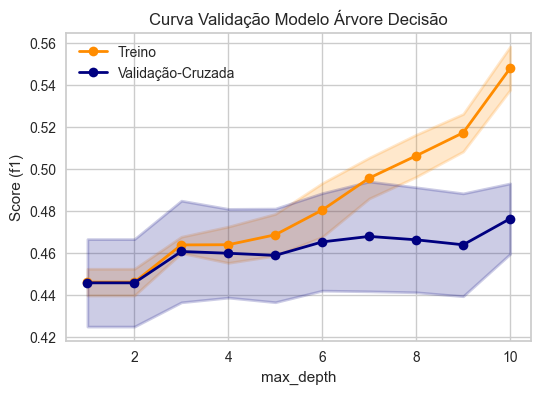

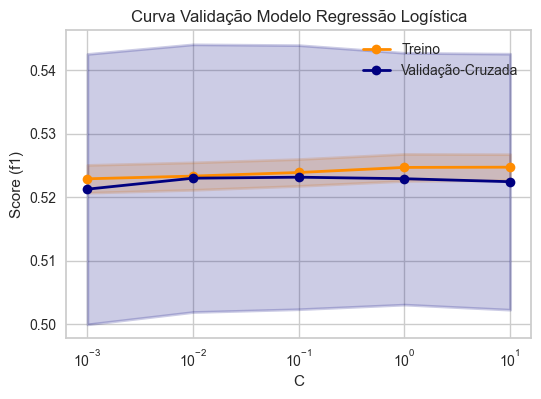

In [18]:
registered_model_name = 'arremessos_kobe'
nexamples = 5
model_version = -1

with mlflow.start_run(experiment_id=experiment_id, run_name = 'Treinamento'):

    #Treinando o modelo utilizando PyCaret
    exp = pc.setup(
        data = x_train,
        target = col_target[0],
        test_data=x_test,
        session_id=123,
        normalize=True,
        log_experiment=False
    )

    list_models = exp.compare_models(['lr','dt'], n_select=2, sort='f1')
    #A função list_models retorna uma lista com os modelos treinados e suas métricas
    #lr = logistic regression
    #dt = decision tree
    #O parametro n_select=2 indica que queremos os 2 melhores modelos
    #O parametro sort='f1' indica que queremos ordenar os modelos pela métrica f1


    #Árvore de Decisão
    dt = list_models[0]
    yhat_test = exp.predict_model(dt)
    plot_parameter_validation_curve(x_train.drop('shot_made_flag', axis=1), y_train, 'max_depth', {'max_depth': [i for i in range(11)]}, 
                                            dt, 'Árvore Decisão', 'f1', logx=False)

    #Salva a imagem do gráfico e carrega para o MLFLOW
    plt.savefig('dt_validation_curve.png')
    mlflow.log_artifact('dt_validation_curve.png')

    #Salva as métricas no MLFLOW
    mlflow.log_metrics({
        'lr_log_loss': log_loss(yhat_test.shot_made_flag, yhat_test.prediction_label),
        'lr_f1': f1_score(yhat_test.shot_made_flag, yhat_test.prediction_label),
    })

    #Regressão Logistica
    lr = list_models[1]
    yhat_test = exp.predict_model(lr)
    plot_parameter_validation_curve(x_train.drop('shot_made_flag', axis=1), y_train, 'C', {'C': [0.001, 0.01, 0.1, 1, 10]},
                                            lr, 'Regressão Logística', 'f1', logx=True)

    #Salva a imagem do gráfico e carrega para o MLFLOW
    plt.savefig('lr_validation_curve.png')
    mlflow.log_artifact('lr_validation_curve.png')

    #Salva as métricas no MLFLOW
    mlflow.log_metrics({
        'dt_log_loss': log_loss(yhat_test.shot_made_flag, yhat_test.prediction_label),
        'dt_f1': f1_score(yhat_test.shot_made_flag, yhat_test.prediction_label),
    })

    #Tunando o melhor modelo com o PyCaret utilizando a métrica f1
    tune_model = exp.tune_model(lr,
                                optimize = 'f1',
                                search_library = 'scikit-learn',
                                search_algorithm = 'random',
                                n_iter = 4)
    yhat_test = exp.predict_model(tune_model, raw_score=True)  
    mlflow.log_metrics({
        'final_model_log_loss': log_loss(yhat_test.shot_made_flag, yhat_test.prediction_label),
        'final_model_f1': f1_score(yhat_test.shot_made_flag, yhat_test.prediction_label),
    })
    yhat_test.to_parquet('processed/prediction_test.parquet')
    mlflow.log_artifact('processed/prediction_test.parquet')
    
    final_model = exp.finalize_model(tune_model)


    # EXPORTACAO PARA LOG E REGISTRO DO MODELO
    exp.save_model(final_model, f'./{registered_model_name}') 
    # Carrega novamente o pipeline + bestmodel
    model_pipe = exp.load_model(f'./{registered_model_name}')
    # Assinatura do Modelo Inferida pelo MLFlow
    model_features = list(x_train.drop('shot_made_flag', axis=1).columns)
    inf_signature = infer_signature(x_train[model_features], 
                                    model_pipe.predict_proba(x_train.drop('shot_made_flag', axis=1)))
    

    # Exemplo de entrada para o MLmodel
    input_example = {x: x_train[x].values[:nexamples] for x in model_features}
    # Log do pipeline de modelagem do sklearn e registrar como uma nova versao
    mlflow.sklearn.log_model(
        sk_model=model_pipe,
        artifact_path="sklearn-model",
        registered_model_name=registered_model_name,
        signature = inf_signature,
        input_example = input_example,
        pyfunc_predict_fn='predict_proba'
    )

    
    # Criacao do cliente do servico MLFlow e atualizacao versao modelo
    client = MlflowClient()
    if model_version == -1:
        model_version = client.get_latest_versions(registered_model_name)[-1].version


    # Registrar o modelo como staging
    client.set_registered_model_alias(
        name    = registered_model_name, 
        alias   = "staging", 
        version = model_version
    )

mlflow.end_run()